Predicting user churn based on transaction data and listening history. Steps include:

1. Clean and normalize data for analysis

2. Exploratory Analysis/Feature Engineering

3. Preprocessing/Model building

4. Predict churn on test data

Note: Criteria of "churn" is no new valid service subscription within 30 days after current membership expires. Transaction data after April 2017 is purposely omitted by the poster. The dataset can be found on https://www.kaggle.com/competitions/kkbox-churn-prediction-challenge/data

# Step 1: Clean and normalize data for analysis

In [2]:
import pandas as pd
import datetime
import numpy as np
pd.set_option('display.max_columns', 500)

In [11]:
traindf = pd.read_csv('train_v2.csv')
transdf = pd.read_csv('transactions_v2.csv', parse_dates = ['transaction_date','membership_expire_date'])
userdf = pd.read_csv(r"C:\Users\marsh\Desktop\Springboard\Capstone2\user_logs_v2.csv", parse_dates = ['date'])
memdf = pd.read_csv('members_v3.csv', parse_dates = ['registration_init_time'])

In [12]:
# merge train and transaction tables, remove null values

df = traindf.merge(transdf, on = 'msno', how = 'left')
df = df.sort_values(['msno','transaction_date'])
df.dropna(inplace= True)
df.isna().sum()
df.dtypes

msno                              object
is_churn                           int64
payment_method_id                float64
payment_plan_days                float64
plan_list_price                  float64
actual_amount_paid               float64
is_auto_renew                    float64
transaction_date          datetime64[ns]
membership_expire_date    datetime64[ns]
is_cancel                        float64
dtype: object

In [18]:
# Let's deal with duplicate user id entries first. Here I aggregate transactions
# with the average time between transactions and membership duration with the 
# sum.

dup = df[df.msno.duplicated()].reset_index()
dup = df[df.msno.isin(dup.msno)]
dup['prev_user'] = dup.msno.shift(1)
dup.iloc[0,10] = '+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw='
dup['avg_time_between_transactions'] = (dup.transaction_date -
                              dup.transaction_date.shift(1)).where(dup.prev_user == dup.msno, 0)
dup.iloc[0,11] = 0
dup['sum_membership_duration'] = dup.membership_expire_date - dup.transaction_date
dup.sum_membership_duration = pd.to_timedelta(dup.sum_membership_duration, unit='d')
dup.sum_membership_duration = dup.sum_membership_duration.dt.days
dup.loc[dup.sum_membership_duration < 0] = 0
dup.avg_time_between_transactions = pd.to_timedelta(dup.avg_time_between_transactions, unit='d')
dup.avg_time_between_transactions = dup.avg_time_between_transactions.dt.days
dup.loc[dup.avg_time_between_transactions< 0] = 0

C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/660429278.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup['prev_user'] = dup.msno.shift(1)
C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/660429278.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup['avg_time_between_transactions'] = (dup.transaction_date -
C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/660429278.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [20]:
# Aggregate remaining columns with the mode or max where it is appropriate.

dup = dup.groupby('msno', as_index = False).agg({'is_churn': lambda x:x.value_counts().index[0],'payment_method_id': lambda x:x.value_counts().index[0], 'payment_plan_days': 'max', 'plan_list_price': 'max',
                                       'actual_amount_paid': 'max', 'is_auto_renew': lambda x:x.value_counts().index[0], 'transaction_date': 'max', 'membership_expire_date': 'max',
                                       'is_cancel': lambda x:x.value_counts().index[0], 'sum_membership_duration': 'sum', 'avg_time_between_transactions': 'mean'})
dup = dup.rename(columns = {'transaction_date': 'latest_transaction', 'membership_expire_date': 'latest_membership_expiration'})
dup.drop(index=dup.index[0], 
        axis=0, 
        inplace=True)

In [22]:
# Create same columns for non-duplicate user id entries, and aggregate remaining
# columns.
nondup = df[~df.msno.isin(dup.msno)]
nondup.sort_values('transaction_date')
nondup['sum_membership_duration'] = nondup.membership_expire_date - nondup.transaction_date
nondup['avg_time_between_transactions'] = 0
nondup.sum_membership_duration = pd.to_timedelta(nondup.sum_membership_duration, unit='d')
nondup.sum_membership_duration = nondup.sum_membership_duration.dt.days
nondup.loc[nondup.sum_membership_duration < 0, 'sum_membership_duration'] = 0
nondup = nondup.groupby('msno', as_index = False).agg({'is_churn': lambda x:x.value_counts().index[0],'payment_method_id': lambda x:x.value_counts().index[0], 'payment_plan_days': 'max', 'plan_list_price': 'max',
                                       'actual_amount_paid': 'max', 'is_auto_renew': lambda x:x.value_counts().index[0], 'transaction_date': 'max', 'membership_expire_date': 'max',
                                       'is_cancel': lambda x:x.value_counts().index[0], 'sum_membership_duration': 'sum', 'avg_time_between_transactions': 'mean'})
nondup = nondup.rename(columns = {'transaction_date': 'latest_transaction', 'membership_expire_date': 'latest_membership_expiration'})


C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/4138481773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nondup['sum_membership_duration'] = nondup.membership_expire_date - nondup.transaction_date
C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/4138481773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nondup['avg_time_between_transactions'] = 0
C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/4138481773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [23]:
df = pd.concat([dup,nondup], ignore_index = True)
df.msno.duplicated().any()

False

In [24]:
# Aggregate user table by sum of songs listened to and the latest listen date.
# Then further calculation on listening history. For example, percent_25 
# indicates how many songs they listen to until only 25% of the song is completed.

userdf = userdf.groupby('msno', as_index = False).agg({'date': 'max', 'num_25': 'sum', 'num_50': 'sum', 'num_75': 'sum',
                                 'num_985': 'sum', 'num_100': 'sum', 'num_unq': 'max', 'total_secs': 'sum'})
userdf['percent_25'] = userdf['num_25']/(userdf['num_25']+userdf['num_50']+userdf['num_75']+userdf['num_985']+userdf['num_100'])
userdf['percent_50'] = userdf['num_50']/(userdf['num_25']+userdf['num_50']+userdf['num_75']+userdf['num_985']+userdf['num_100'])
userdf['percent_100'] = (userdf['num_985']+userdf['num_100'])/(userdf['num_25']+userdf['num_50']+userdf['num_75']+userdf['num_985']+userdf['num_100'])
userdf = userdf.drop(columns = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

In [25]:
# merge user table with previous table and remove null values
df1 = df.merge(userdf, how = 'left')
df1 = df1.dropna()
df1 = df1.rename(columns = {'date' : 'latest_listen_date'})
df1.isnull().sum()

msno                             0
is_churn                         0
payment_method_id                0
payment_plan_days                0
plan_list_price                  0
actual_amount_paid               0
is_auto_renew                    0
latest_transaction               0
latest_membership_expiration     0
is_cancel                        0
sum_membership_duration          0
avg_time_between_transactions    0
latest_listen_date               0
num_unq                          0
total_secs                       0
percent_25                       0
percent_50                       0
percent_100                      0
dtype: int64

In [26]:
# merge member table with previous table, and drop gender column since over 50% 
# of it contains null values.
memdf = pd.read_csv('members_v3.csv', parse_dates = ['registration_init_time'])
df1 = df1.merge(memdf, on = 'msno',how = 'left')
df1.drop(columns = ['bd','gender'], inplace = True)
df1 = df1.dropna()
df1.to_csv('Capstone updated 126023.csv',index = False)

# Step 2. Exploratory Data Analysis

In [3]:
import matplotlib.pyplot as plt
import matplotlib.axes
import seaborn as sns

In [28]:
df = pd.read_csv('Capstone updated 126023.csv', parse_dates = ['latest_transaction','latest_membership_expiration','latest_listen_date','registration_init_time'])

46603 0.06421604967191294


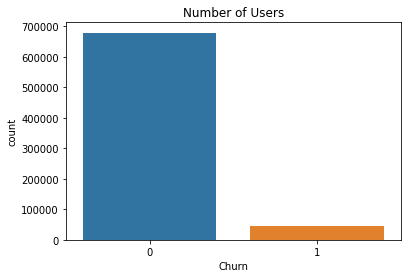

In [29]:
# I will look at each feature to see if there is any visible relationship with
# user churn.

totusers = len(df['msno'])
not_churn = df[df['is_churn'] == 0]
is_churn = df[df['is_churn'] == 1]
sns.countplot(x = 'is_churn', data = df)
plt.title('Number of Users')
plt.xlabel('Churn')
print(len(is_churn), len(is_churn) / totusers)


# Total of 6% of users appeared to have churned.

In [32]:
df[['is_churn', "sum_membership_duration"]].groupby("is_churn").agg({"sum_membership_duration":['mean', 'count','sum']})

# Total membership duration is highly correlated with user churn. 

sum_membership_duration                  
                            mean   count       sum
is_churn                                          
0                      94.090395  679119  63898575
1                     272.285840   46603  12689337

<AxesSubplot: xlabel='is_churn', ylabel='sum_membership_duration'>

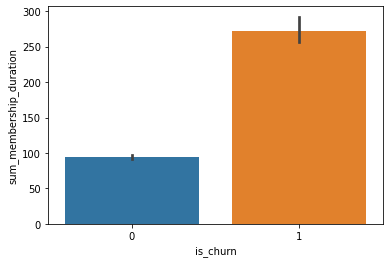

In [33]:
sns.barplot(x = df.is_churn, y= df.sum_membership_duration)

# After plotting it, users with longer memberships seem more likely to churn.

[Text(0, 0, '0-30.708 days'),
 Text(1, 0, '30.709-31.377 days'),
 Text(2, 0, '31.378-31.982 days'),
 Text(3, 0, '>31.982 days')]

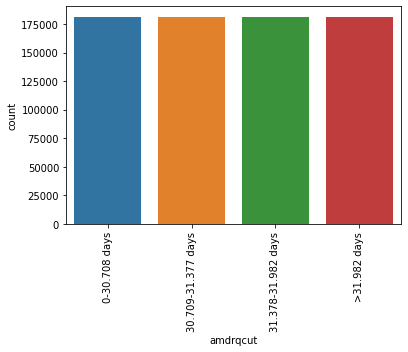

In [52]:
# Here, I use the pandas qcut function to see time interval is associated with
# user churn.

df['amdrqcut'] = df['sum_membership_duration'].apply(lambda x: x + np.random.random())
df['amdrqcut'] = pd.qcut(x= df["amdrqcut"], q = 4,duplicates = 'drop')

x = sns.countplot(x = 'amdrqcut', data = df)
x.set_xticklabels(labels = ['0-30.708 days','30.709-31.377 days','31.378-31.982 days','>31.982 days'],rotation = 90)

([0, 1, 2, 3],
 [Text(0, 0, '(-0.00068, 30.749]'),
  Text(1, 0, '(30.749, 31.407]'),
  Text(2, 0, '(31.407, 32.052]'),
  Text(3, 0, '(32.052, 203901.815]')])

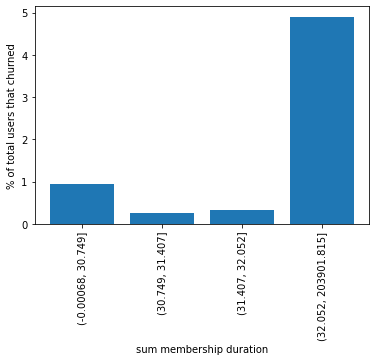

In [53]:
df['amdrqcut'] = df.amdrqcut.astype(str)
amdrqcut = df.groupby('amdrqcut').sum()['is_churn'] /totusers *100

x = plt.bar(amdrqcut.index, amdrqcut.values)
plt.xlabel('sum membership duration')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')

# Users that have memberships longer than 32 days are very likely to churn.

(0.0, 30.0)

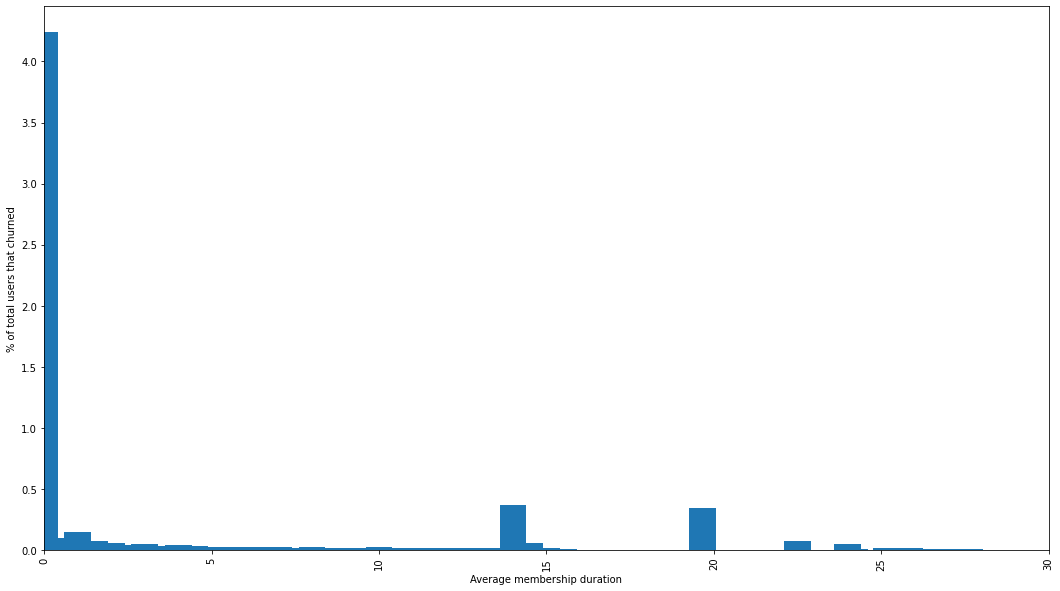

In [35]:
# Let's take a look at average time between transactions.

df.sort_values('avg_time_between_transactions')
df.avg_time_between_transactions = round(df.avg_time_between_transactions,2)
atbt = df.groupby('avg_time_between_transactions').sum()['is_churn'] /totusers *100
plt.figure(figsize=(18,10))
plt.bar(atbt.index, atbt.values)
plt.xlabel('Average membership duration')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')
plt.xlim([0,30])

# It looks like users with 0 transactions also churn more often.

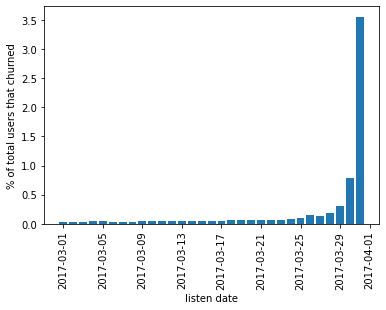

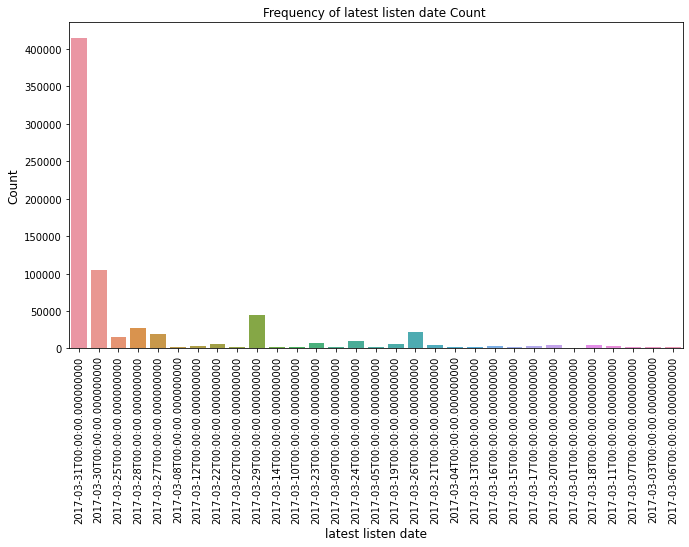

In [36]:
# Then we look at latest listen date. 

listen = df.groupby('latest_listen_date').sum()['is_churn'] / totusers *100

plt.bar(listen.index, listen.values)
plt.xlabel('listen date')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')


plt.figure(figsize=(11,6))
sns.countplot(x="latest_listen_date", data=df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('latest listen date', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of latest listen date Count ", fontsize=12)
plt.show()

# Though it appears that many users churned in March, there are also far more 
# entries with a listen date in late March. Therefore, there isn't an obvious
# conclusion that can be drawn here.

(0.0, 250.0)

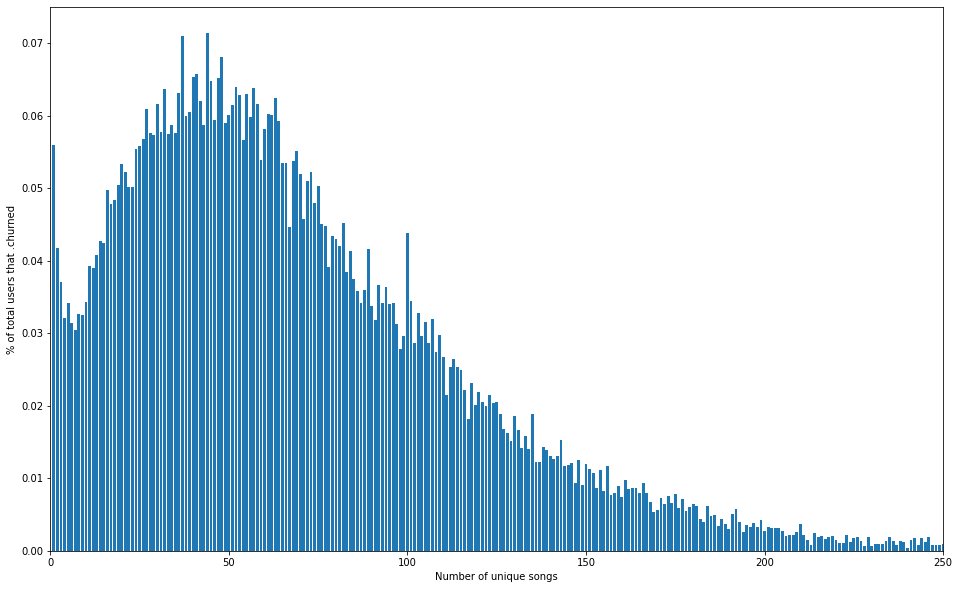

In [39]:
# Next, we look at the number of unique songs each user has listened to.

unq = df.groupby('num_unq').sum()['is_churn']
unq = unq / totusers * 100
plt.figure(figsize = (16,10))
plt.bar(list(unq.index), list(unq))
plt.xlabel('Number of unique songs')
plt.ylabel('% of total users that .churned')
plt.xlim([0,250])

# There's a spike in churned users that only listen to around 40-50 unique songs.

([<matplotlib.axis.XTick at 0x1750eea3880>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

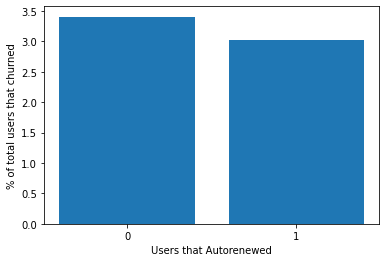

In [40]:
# Next, we look at auto-renewal.

autorenew = df.groupby('is_auto_renew').sum()['is_churn']
autorenew = autorenew / totusers *100
plt.bar(list(autorenew.index), list(autorenew))
plt.xlabel('Users that Autorenewed')
plt.ylabel('% of total users that churned')
plt.xticks(ticks = [0,1])

# No visible correlation to churn rate.

([<matplotlib.axis.XTick at 0x1750fdd3670>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

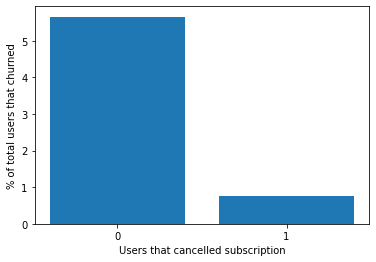

In [41]:
# Next, we'll look at users that actively canceled their subscription.

cancel = df.groupby('is_cancel').sum()['is_churn']
cancel = cancel / totusers * 100
plt.bar(list(cancel.index), list(cancel))
plt.xlabel('Users that cancelled subscription')
plt.ylabel('% of total users that churned')
plt.xticks(ticks = [0,1])

# It's unusal that users that cancel were less likely to churn. It may be due 
# to the fact that cancellations are due to a change in subscription plan.

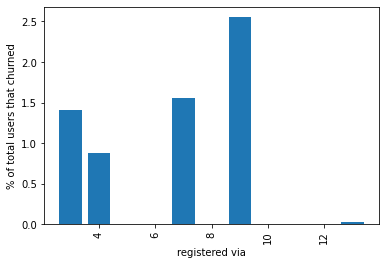

In [44]:
# Next, we'll look at registration method.

reg = df.groupby('registered_via').sum()['is_churn'] / totusers *100

plt.bar(reg.index, reg.values)
plt.xlabel('registered via')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')
plt.show()

# Those who registered with methods 7 and 9 appeared to have churned more often
# than users who registered via other methods.

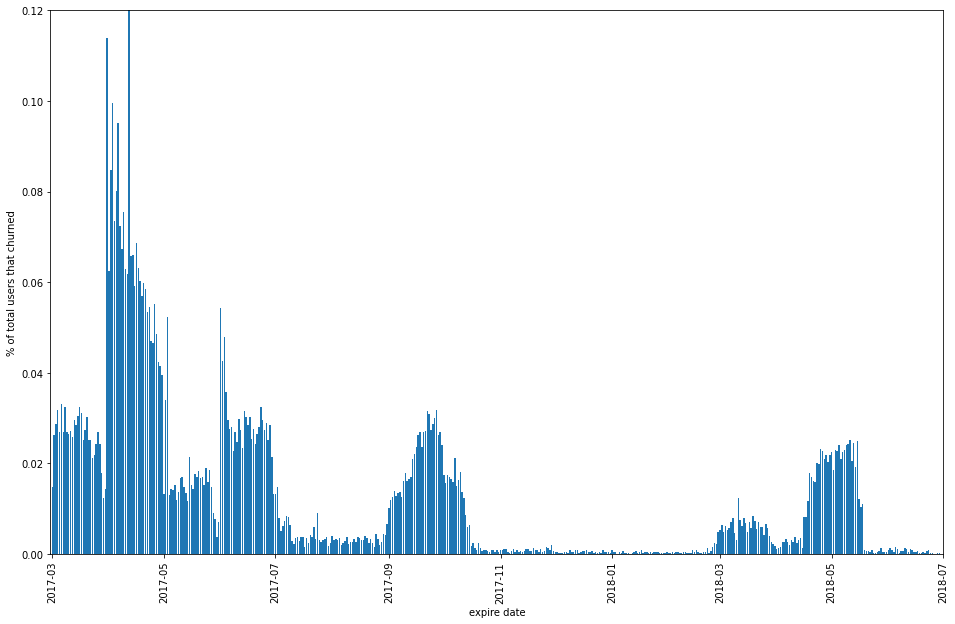

In [45]:
# Next, we'll look at latest membership expiration.

expire = df.groupby('latest_membership_expiration').sum()['is_churn'] / totusers *100
plt.figure(figsize = (16,10))
plt.bar(expire.index, expire.values)
plt.xlabel('expire date')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')
plt.xlim([datetime.date(2017, 2, 28), datetime.date(2018, 7,1)])
plt.ylim([0,0.12])
plt.show()

# We see a large spike in user churn when membership expiration date falls in 
# the April timeframe. This may be due to there being more entries for April users.

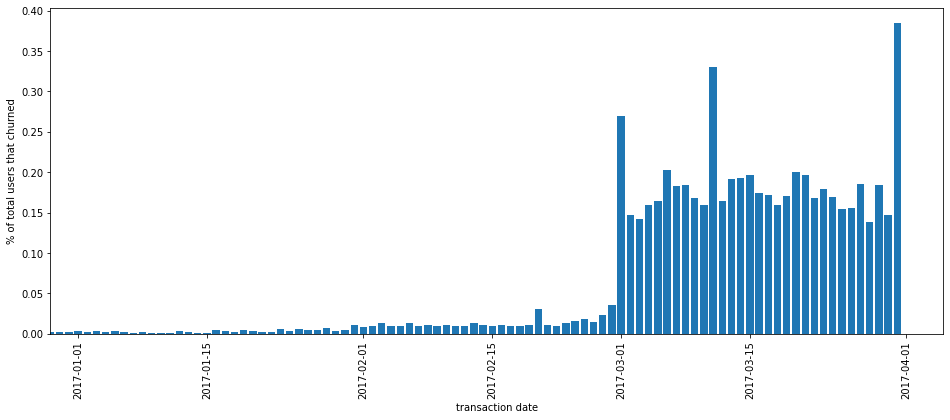

In [50]:
# Next, transaction data.

transaction = df.groupby('latest_transaction').sum()['is_churn'] / totusers *100
plt.figure(figsize = (16,6))
plt.bar(transaction.index, transaction.values)
plt.xlabel('transaction date')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')
plt.xlim([datetime.date(2016, 12, 29), datetime.date(2017, 4,5)])
plt.show()

# Again, there is a large spike in user churn in March. This may be due to
# there being more transaction entries in March. This also aligns with
# our April expiration date spike since most users choose monthly subscription 
# plans.

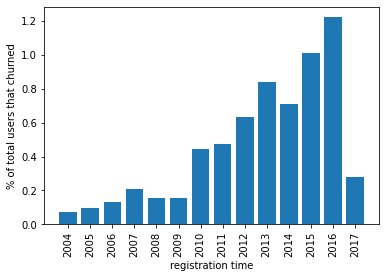

In [51]:
# Next, we'll look at registration date by year.

df['year'] = pd.to_datetime(df['registration_init_time']).dt.to_period('Y')
df['year'] = df.year.astype(str)
regtime = df.groupby('year').sum()['is_churn'] / totusers *100
plt.bar(regtime.index, regtime.values)
plt.xlabel('registration time')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')
plt.show()

# The data shows a high spike in user churn leading up to 2017.

[Text(0, 0, '0-99.799 NTD'),
 Text(1, 0, '99.80-149.242 NTD'),
 Text(2, 0, '149.243-149.764 NTD'),
 Text(3, 0, '>149.765 NTD')]

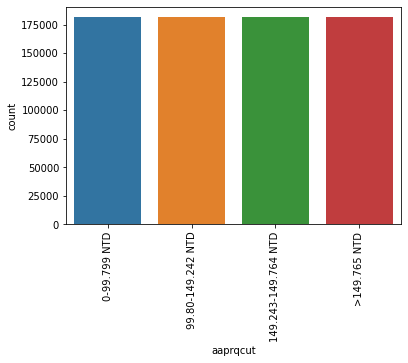

In [55]:
# Next, I'll use the qcut function again to see if there is any correlation between
# actual amount paid and user churn, which is highly likely.
df['actual_amount_rand'] = df['actual_amount_paid'].apply(lambda x: x + np.random.random())
df['aaprqcut'] = pd.qcut(x= df["actual_amount_rand"], q = 4,duplicates = 'drop')
x = sns.countplot(x = 'aaprqcut', data = df)
x.set_xticklabels(labels = ['0-99.799 NTD','99.80-149.242 NTD','149.243-149.764 NTD','>149.765 NTD'],rotation = 90)

([0, 1, 2, 3],
 [Text(0, 0, '(-0.000741, 99.799]'),
  Text(1, 0, '(149.242, 149.765]'),
  Text(2, 0, '(149.765, 2000.928]'),
  Text(3, 0, '(99.799, 149.242]')])

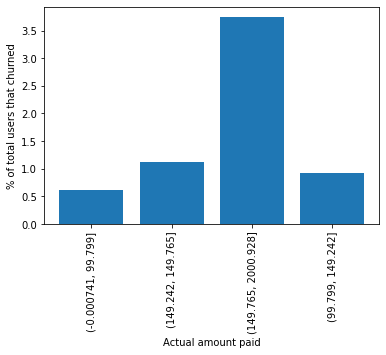

In [56]:
df['aaprqcut'] = df.aaprqcut.astype(str)
aaprqcut = df.groupby('aaprqcut').sum()['is_churn'] /totusers *100

x = plt.bar(aaprqcut.index, aaprqcut.values)
plt.xlabel('Actual amount paid')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')

# Users that pay more are more likely to churn. This aligns with our previous
# analysis of total membership duration. In other words, longer memberships =
# higher amount paid = higher churn rate

<AxesSubplot: title={'center': 'Distribution of Actual Amount Paid'}, xlabel='Actual Amount paid', ylabel='Frequency'>

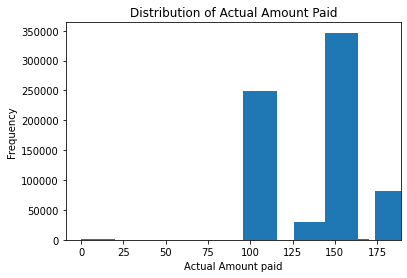

In [57]:
# Plotting the histogram of actual amount paid shows that those who pay more than
# 150 Taiwan dollars make up less than 25% of our dataset.

plt.title('Distribution of Actual Amount Paid')
plt.xlabel('Actual Amount paid')
df.loc[df['actual_amount_paid'] < 250, 'actual_amount_paid'].plot.hist(bins = 30, width = 20)

[Text(0.5, 0, 'Payment plan days'), Text(0, 0.5, 'count')]

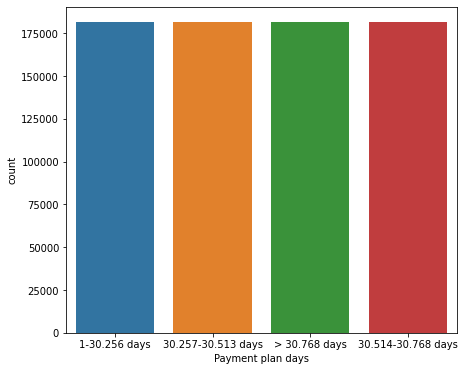

In [58]:
# Next, we'll look at payment plan days. I will utilize the qcut function again.

df['ppdrqcut'] = df['payment_plan_days'].apply(lambda x: x + np.random.random())

df['ppdrqcut'] = pd.qcut(x= df["ppdrqcut"], q = 4,duplicates = 'drop', labels = ['1-30.256 days','30.257-30.513 days'
                                                                                , '30.514-30.768 days','> 30.768 days'])
df['ppdrqcut'] = df.ppdrqcut.astype(str)
plt.figure(figsize=(7,6))
plt.xlabel('payment plan days')
ax = sns.countplot(x = 'ppdrqcut', data = df)
ax.set(xlabel = 'Payment plan days', ylabel = 'count')

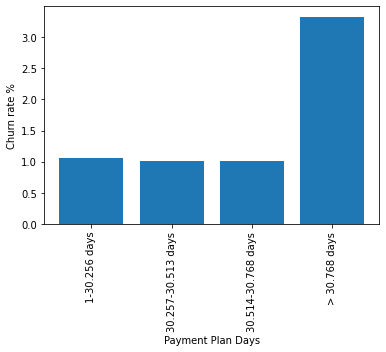

In [59]:
ppd = df.groupby('ppdrqcut').sum()['is_churn'] /totusers *100
plt.bar(ppd.index, ppd.values)
plt.xlabel('Payment Plan Days')
plt.ylabel('Churn rate %')
plt.xticks(rotation= 'vertical')
plt.show()

# Users that opt for payment plans longer than 30 days are more likely to churn,
# which is to be expected. There's a trend showing that to users who opt for
# longer memberships are more likley to churn than users who choose have shorter
# memberships.

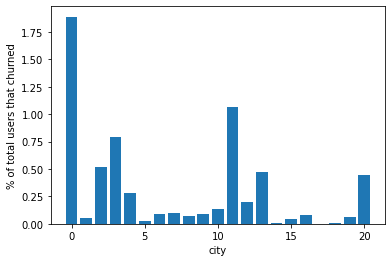

In [60]:
# Next, we'll look at cities.

city = df.groupby('city').sum()['is_churn'] / totusers * 100
plt.bar(np.arange(len(list(city.index))), list(city))
plt.xlabel('city')
plt.ylabel('% of total users that churned')
plt.show()

# Users in city 0 (the exact city is unknown to us) are more likely to churn.

<AxesSubplot: xlabel='is_churn', ylabel='total_secs'>

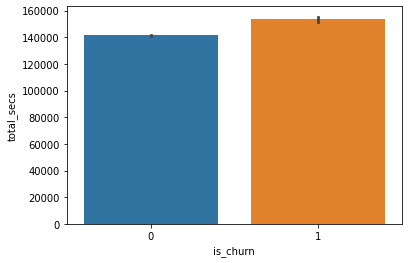

In [45]:
# Next, we'll look at total secs vs churn rate.

sns.barplot(x = df.is_churn, y= df.total_secs)

# No visible correlation here.

<AxesSubplot: xlabel='is_churn', ylabel='percent_25'>

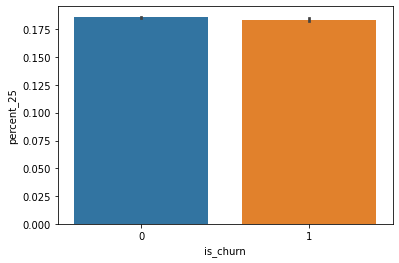

In [18]:
# Next, we'll look at all percentages vs churn rate.

sns.barplot(x = df.is_churn, y = df.percent_25)

<AxesSubplot: xlabel='is_churn', ylabel='percent_50'>

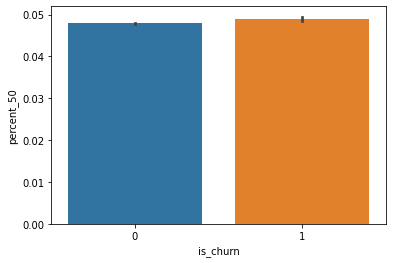

In [19]:
sns.barplot(x = df.is_churn, y = df.percent_50)

<AxesSubplot: xlabel='is_churn', ylabel='percent_100'>

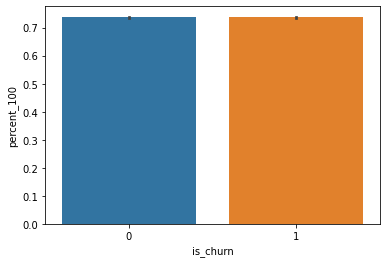

In [20]:
sns.barplot(x = df.is_churn, y = df.percent_100)

# No visible correlations between song completion percentage and churn rate.

<AxesSubplot: >

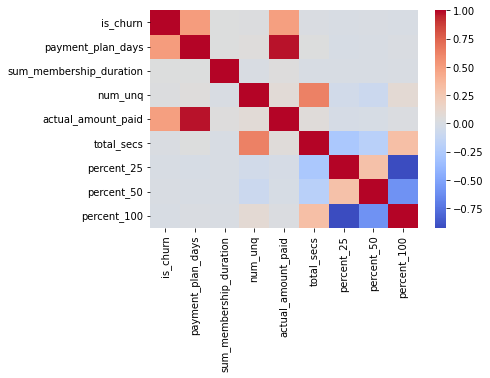

In [65]:
# For good measure, let's take a look at the heatmap to see if there are any 
# other correlations we may be missing.

num = df[['is_churn','payment_plan_days','sum_membership_duration','num_unq','actual_amount_paid','total_secs','percent_25','percent_50','percent_100']]
num
sns.heatmap(num.corr(),cmap = 'coolwarm')

Conclusions: We see a couple of interesting trends here. Users with longer memberships have a higher churn rate than users with short memberships. In other words, users that opt for payment plans greater than 30 days are likely to churn. Listening history also seems to correlate with churn rate. 

It is possible that focusing on retaining long-term users will be the most effective strategy to help reduce churn rate.

# Step 3: Preprocessing/Model building

In [4]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [5]:
df = pd.read_csv('Capstone updated 126023.csv', parse_dates = ['latest_transaction','latest_membership_expiration','latest_listen_date','registration_init_time'])
# Process dates for our model.

df['latest_transaction_year'] = df['latest_transaction'].dt.year
df['latest_transaction_month'] = df['latest_transaction'].dt.month
df['latest_transaction_week'] = df['latest_transaction'].dt.week
df['latest_transaction_day'] = df['latest_transaction'].dt.day

df['latest_membership_expiration_year'] = df['latest_membership_expiration'].dt.year
df['latest_membership_expiration_month'] = df['latest_membership_expiration'].dt.month
df['latest_membership_expiration_week'] = df['latest_membership_expiration'].dt.week
df['latest_membership_expiration_day'] = df['latest_membership_expiration'].dt.day

df['latest_listen_date_year'] = df['latest_listen_date'].dt.year
df['latest_listen_date_month'] = df['latest_listen_date'].dt.month
df['latest_listen_date_week'] = df['latest_listen_date'].dt.week
df['latest_listen_date_day'] = df['latest_listen_date'].dt.day

df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_week'] = df['registration_init_time'].dt.week
df['registration_init_time_day'] = df['registration_init_time'].dt.day

df = df.drop(columns = ['latest_transaction','latest_membership_expiration','latest_listen_date','registration_init_time'])

C:\Users\marsh\AppData\Local\Temp/ipykernel_17036/1875495377.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['latest_transaction_week'] = df['latest_transaction'].dt.week
C:\Users\marsh\AppData\Local\Temp/ipykernel_17036/1875495377.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['latest_membership_expiration_week'] = df['latest_membership_expiration'].dt.week
C:\Users\marsh\AppData\Local\Temp/ipykernel_17036/1875495377.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['latest_listen_date_week'] = df['latest_listen_date'].dt.week
C:\Users\marsh\AppData\Local\Temp/ipykernel_17036/1875495377.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df

In [7]:
# Divide our train and test data, then scale/transform using a Standard Scaler.
X = df.drop(columns = ['is_churn','msno'])
y = df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)
scaler = StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [73]:
# I'll test the performance of three models: A Random Forest, Logistic 
# Regression, and Extreme Gradient Boost. Let's try the Random Forest first.

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, random_state = 42,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

In [75]:
# Use cross-validation to determine the best hyperparameters.

max_depth = [6,10,20]
n_estimators = [10,50,100]
max_features = ['auto','sqrt']
max_depth,n_estimators

rfc_pipe = Pipeline(
steps = [('standardscaler', StandardScaler()),
('classifier', RandomForestClassifier())])


grid_params = {'standardscaler': [StandardScaler(),None],
               'classifier__n_estimators' : n_estimators,
               'classifier__max_depth': max_depth,
              'classifier__max_features': max_features
}

rfc_grid_cv = RandomizedSearchCV(rfc_pipe, param_distributions = grid_params, cv = StratifiedKFold(5), n_jobs = -1, scoring = 'f1')
model = rfc_grid_cv.fit(X_train,y_train)
model.best_params_

{'standardscaler': StandardScaler(),
 'classifier__n_estimators': 100,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 20}

In [53]:
# Let's fit our data using these parameters and print the classification report.
# The best metric to determine performance will be F1 score since we want to 
# focus on true positive labels.

tune_rfc = RandomForestClassifier(n_estimators=100, max_features = 'auto', max_depth = 20, random_state = 42,n_jobs=-1)

    
model_res = tune_rfc.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

y_pred_test = tune_rfc.predict(X_test_scaled)
y_pred_train = tune_rfc.predict(X_train_scaled)
print(classification_report(y_train, y_pred_train)), print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509339
           1       1.00      0.88      0.94     34952

    accuracy                           0.99    544291
   macro avg       0.99      0.94      0.97    544291
weighted avg       0.99      0.99      0.99    544291

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    169780
           1       0.94      0.84      0.89     11651

    accuracy                           0.99    181431
   macro avg       0.96      0.92      0.94    181431
weighted avg       0.99      0.99      0.99    181431



(None, None)

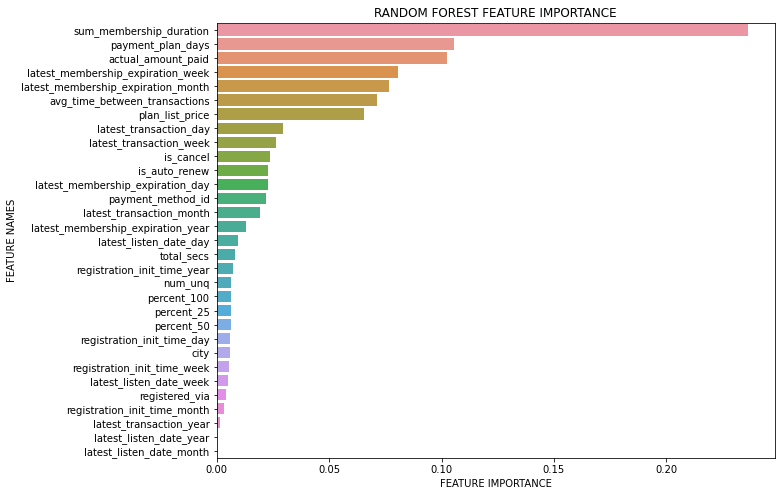

In [61]:
# Here I create a function to plot feature importance.

def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(model_res.feature_importances_,X_train.columns, 'RANDOM FOREST')

# We can see that as expected, membership duration and payments are the top features in determining
# churn rate for the random forest.

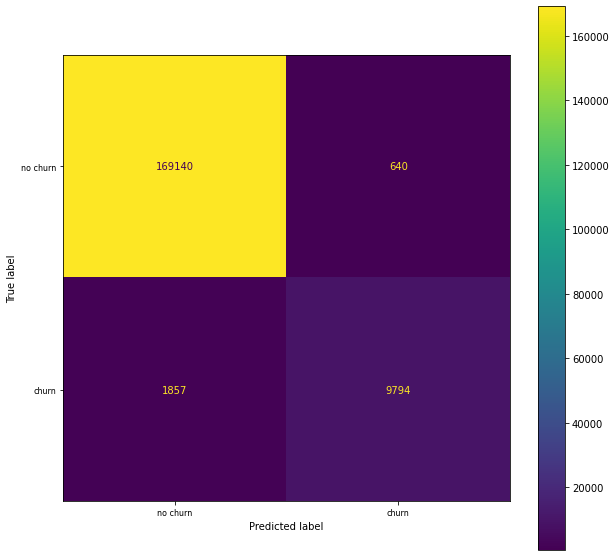

In [78]:
# Let's plot the confusion matrix.

cm = confusion_matrix(y_test, y_pred, labels = tune_rfc.classes_)
fig, ax = plt.subplots(figsize = (10,10))
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no churn', 'churn'],
                                   )
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no churn', 'churn'], fontsize = 8)
ax.set_yticklabels(labels = ['no churn', 'churn'], fontsize = 8)
display_cm.plot(ax = ax)

# Not bad! Our Random Forest has an F1 score of 89, and correctly predicts 9794 
# churned users.

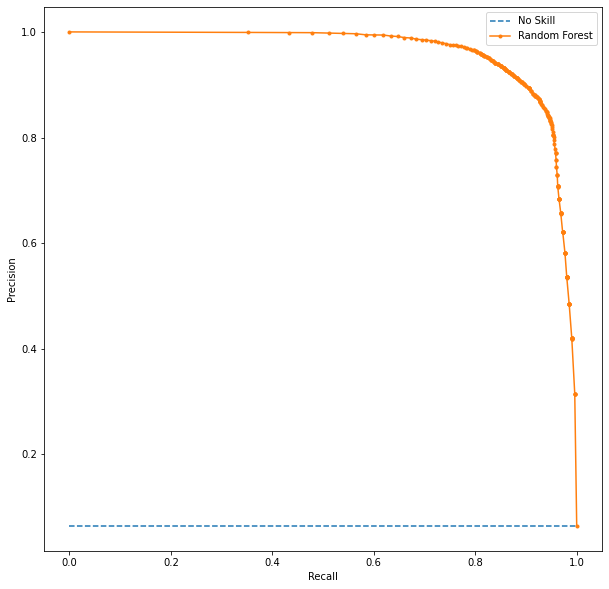

In [79]:
# Plotting the Precision-Recall curve for the Random Forest shows this is a
# good model in terms of performance.
model = RandomForestClassifier( n_estimators=100, random_state = 42, max_depth = 20, max_features = 'auto',
                             n_jobs=-1)
model = model.fit(X_train_scaled,y_train)
plt.figure(figsize=(10,10))
rf_probs = model.predict_proba(X_test_scaled)
rf_probs = rf_probs[:,1]
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [80]:
# Now let's try Logistic Regression.


lr = LogisticRegression(solver = 'liblinear', max_iter = 500)
model_res = lr.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

In [81]:
# Use Randomized Search cross validation to determine the best hyperparameters.

C = [100,10,1.0,0.1,0.01]
solver = ['newton-cg','lbfgx','liblinear']


lr_pipe = Pipeline(
steps = [('standardscaler', StandardScaler()),
('classifier', LogisticRegression())])


grid_params = {'standardscaler': [StandardScaler(),None],
               'classifier__C' : C,
               'classifier__solver': solver
}

lr_grid_cv = RandomizedSearchCV(lr_pipe, param_distributions = grid_params, cv = StratifiedKFold(5), n_jobs = -1, scoring = 'f1')
model = lr_grid_cv.fit(X_train,y_train)
model.best_params_

C:\Users\marsh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.65832827 0.65832836 0.59064345 0.49693225 0.49805532
        nan 0.64731155 0.65845913 0.4962348 ]
  warnings.warn(


{'standardscaler': StandardScaler(),
 'classifier__solver': 'newton-cg',
 'classifier__C': 10}

In [82]:
# Fit the model with above hyperparameters.

tune_lr = LogisticRegression(solver = 'newton-cg', C = 10, random_state = 42,n_jobs=-1)

    
model_res = tune_lr.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

y_pred_test = tune_lr.predict(X_test_scaled)
y_pred_train = tune_lr.predict(X_train_scaled)
print(classification_report(y_train, y_pred_train)), print(classification_report(y_test,y_pred_test))

# We show a huge dip in performance for the Logistic Regression model. A PR
# curve and confusion matrix reinforces this.

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    509339
           1       0.85      0.54      0.66     34952

    accuracy                           0.96    544291
   macro avg       0.91      0.77      0.82    544291
weighted avg       0.96      0.96      0.96    544291

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    169780
           1       0.84      0.53      0.65     11651

    accuracy                           0.96    181431
   macro avg       0.91      0.76      0.82    181431
weighted avg       0.96      0.96      0.96    181431



(None, None)

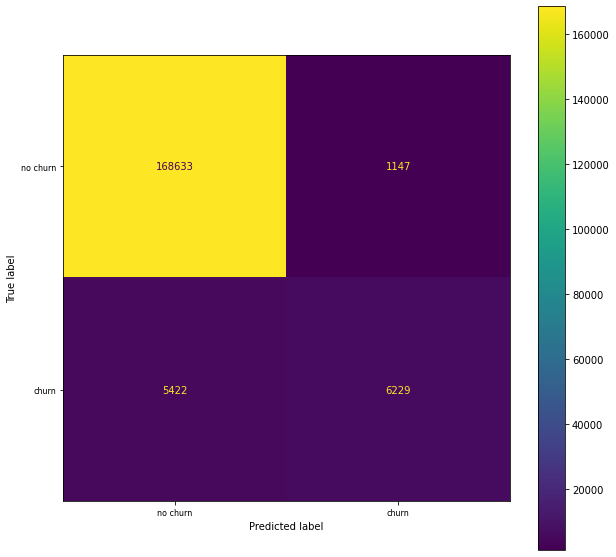

In [83]:
cm = confusion_matrix(y_test, y_pred_test, labels = lr.classes_)
fig, ax = plt.subplots(figsize = (10,10))
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no churn', 'churn'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no churn', 'churn'], fontsize = 8)
ax.set_yticklabels(labels = ['no churn', 'churn'], fontsize = 8)
display_cm.plot(ax = ax)

# The model only correctly predicts 6229 churn users.

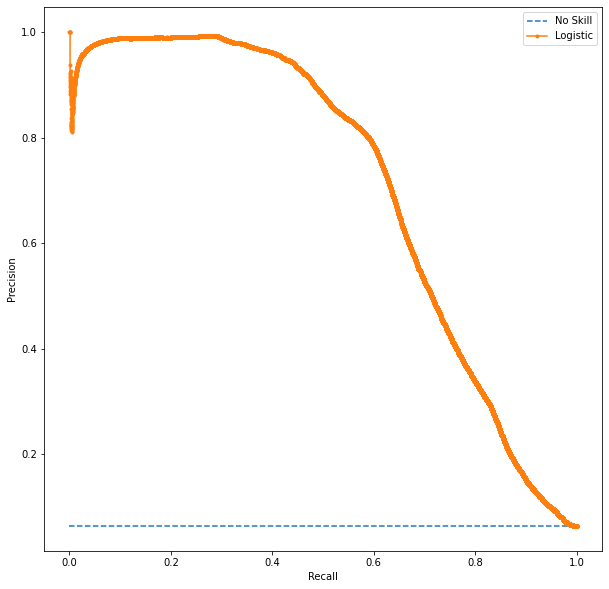

In [85]:
model = tune_lr.fit(X_train_scaled,y_train)
plt.figure(figsize=(10,10))
lr_probs = model.predict_proba(X_test_scaled)
lr_probs = lr_probs[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [86]:
# Lastly, let's try an Extreme Gradient Boost.
xgb = XGBClassifier()
model = xgb.fit(X_train_scaled, y_train)
y_pred = model.predict(X_train_scaled)


In [87]:
max_depth = [6,10,20]
n_estimators = [10,100,1000]
min_child_weight = [1,5,100]
max_depth,n_estimators

xgb_pipe = Pipeline(
steps = [('standardscaler', StandardScaler()),
('classifier', XGBClassifier())])


grid_params = {'standardscaler': [StandardScaler(),None],
               'classifier__n_estimators' : n_estimators,
               'classifier__max_depth': max_depth,
               'classifier__min_child_weight': min_child_weight
}

xgb_grid_cv = RandomizedSearchCV(xgb_pipe, param_distributions = grid_params, cv = StratifiedKFold(5), n_jobs = -1, scoring = 'f1')
model = xgb_grid_cv.fit(X_train,y_train)
model.best_params_

{'standardscaler': None,
 'classifier__n_estimators': 100,
 'classifier__min_child_weight': 1,
 'classifier__max_depth': 20}

In [46]:
# After fitting the model with the above hyperparameters, we see that the XGB
# performs slightly better than the random forest.

tune_xgb = XGBClassifier(n_estimators = 100, min_child_weight = 1, max_depth = 20, 
                             random_state = 42)
tune_model = tune_xgb.fit(X_train_scaled, y_train)
y_pred_test = tune_model.predict(X_test_scaled)
y_pred_train = tune_model.predict(X_train_scaled)
print(classification_report(y_train, y_pred_train)), print(classification_report(y_test,y_pred_test))

model = tune_xgb.fit(X_train,y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    509339
           1       1.00      1.00      1.00     34952

    accuracy                           1.00    544291
   macro avg       1.00      1.00      1.00    544291
weighted avg       1.00      1.00      1.00    544291

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    169780
           1       0.91      0.88      0.90     11651

    accuracy                           0.99    181431
   macro avg       0.95      0.94      0.94    181431
weighted avg       0.99      0.99      0.99    181431



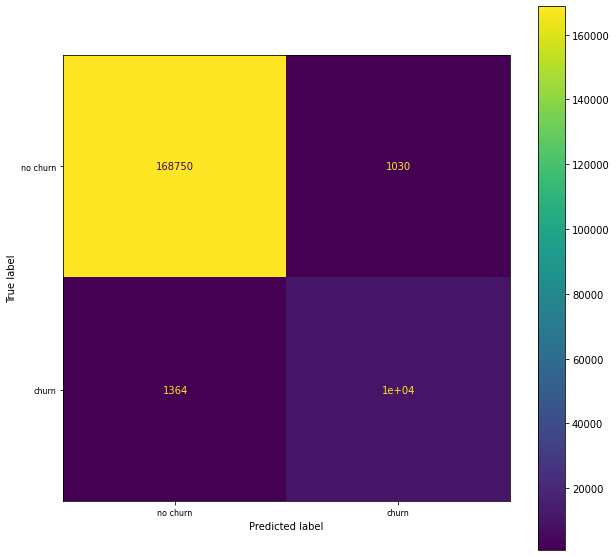

In [89]:
# Let's also plot the confusion matrix and PR curve for good measure.

cm = confusion_matrix(y_test, y_pred_test, labels = xgb.classes_)
fig, ax = plt.subplots(figsize =(10,10))
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no churn', 'churn'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no churn', 'churn'], fontsize = 8)
ax.set_yticklabels(labels = ['no churn', 'churn'], fontsize = 8)
display_cm.plot(ax = ax)

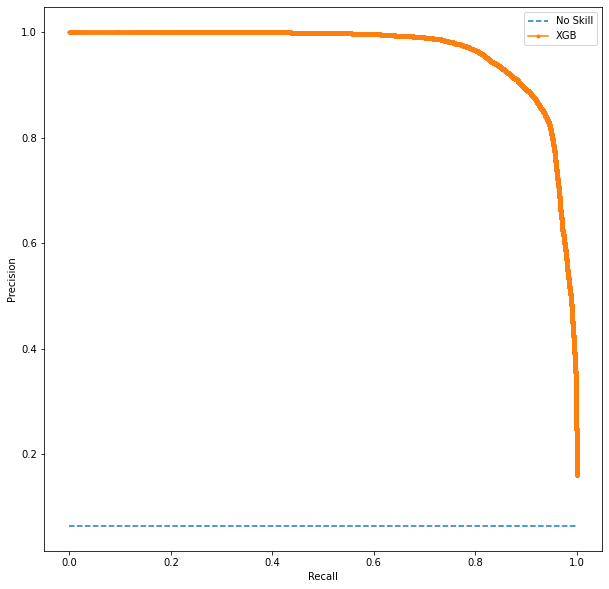

In [26]:
plt.figure(figsize=(10,10))
model = XGBClassifier(n_estimators = 100, min_child_weight = 1, max_depth = 20, 
                             random_state = 42)
model = model.fit(X_train_scaled,y_train)

xgb_probs = model.predict_proba(X_test_scaled)
xgb_probs = xgb_probs[:,1]
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()


In [47]:
# Plot the feature importances. We see that total membership duration is highly correlated with 
# churn rate, as expected after EDA.

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

tune_xgb = XGBClassifier(n_estimators = 100, min_child_weight = 1, max_depth = 20, 
                             random_state = 42)
tune_model = tune_xgb.fit(X_train, y_train)



In [3]:
# Let's record all test scores on a table.

scores = {'Model': ['Random Forest','Logistic Regression', 'XGB'], 'Precision': [0.94,0.84,0.91], 'Recall': [0.84,0.53,0.88], 'f1-score' : [0.89,0.65,0.90]}
scores = pd.DataFrame(scores)
scores

,Model,Precision,Recall,f1-score
0,Random Forest,0.94,0.84,0.89
1,Logistic Regression,0.84,0.53,0.65
2,XGB,0.91,0.88,0.90


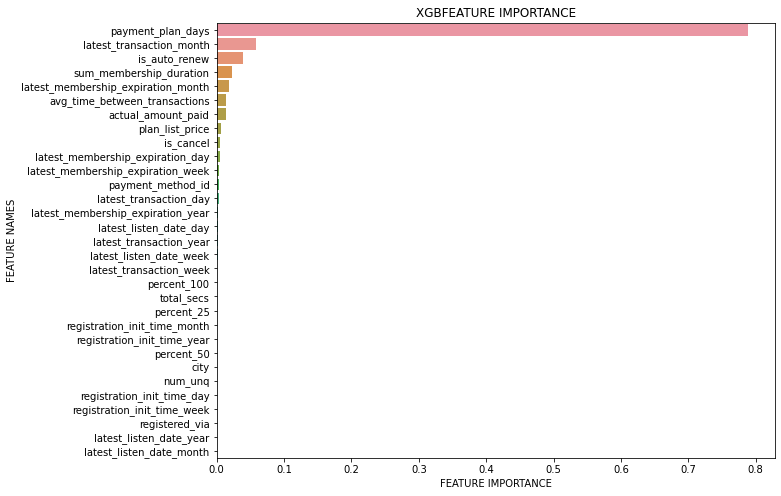

In [59]:
# Similar to the random forest, let's plot the feature importances for our XGB model.

plot_feature_importance(tune_model.feature_importances_,X_train.columns, 'XGB')

# We see here that it considers payment plan days as the most important feature by far when
# determining user churn. Total membership comes in at fourth , and actual amount paid is surprisingly
# low at seventh. Even though this is surprising, I'll still be going with XGB since it has a 
# higher recall score.

Conclusions: Since we are focusing on true positive rate, I decided to go with the Extreme Gradient Boosted model due to its higher F1 and recall scores. The feature importances line up with our preliminary analysis in that the top three features that affect user churn are payment plan days, total membership duration, and actual amount paid. Now I'll test this model using brand new data, which is also taken from the same Kaggle post.

# Step 4: Predict churn using new data

In [152]:
# I've normalized the test data in the same formats as our train data. The code will be the exact same
# as when we cleaned the train data.

test_df = pd.read_csv('test_data.csv')
test_df

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,sum_membership_duration,avg_time_between_transactions,num_unq,total_secs,percent_25,percent_50,percent_100,city,registered_via,latest_transaction_year,latest_transaction_month,latest_transaction_week,latest_transaction_day,latest_membership_expiration_year,latest_membership_expiration_month,latest_membership_expiration_week,latest_membership_expiration_day,latest_listen_date_year,latest_listen_date_month,latest_listen_date_week,latest_listen_date_day,registration_init_time_year,registration_init_time_month,registration_init_time_week,registration_init_time_day
0,++jbV49/2rayAbDFcuc17mtZklsc9Ob/kHmGQfsTrLI=,41.0,30.0,99.0,99.0,1.0,0.0,474,197.000000,246.0,28328.795,0.668354,0.060759,0.245570,1.0,7.0,2017,3,10,10,2017,4,17,27,2017,3,13,30,2011,10,42,19
1,++kosgi4V03jOxcBKjM/9tPignUOxcc7jBVnZLJ+lX0=,41.0,30.0,149.0,149.0,1.0,0.0,61,4.666667,42.0,121449.944,0.241727,0.063309,0.656115,1.0,7.0,2017,3,12,24,2017,4,16,23,2017,3,13,31,2015,7,28,10
2,+0KcMm8JNCW08lTp3Lyz5Ger/47u3yj9H2xLf8lyAj8=,41.0,30.0,149.0,149.0,1.0,0.0,15643,36.894737,22.0,29609.154,0.057971,0.007246,0.927536,1.0,7.0,2017,3,11,13,2018,9,37,13,2017,3,13,30,2013,3,11,13
3,+0QQxbBbymdYyBxpsY6/LrijzjL/Qte1eej3g/v+wWw=,41.0,30.0,149.0,149.0,1.0,0.0,1041,162.333333,98.0,352087.011,0.038920,0.006905,0.953547,1.0,7.0,2017,3,13,31,2017,5,18,4,2017,3,13,31,2010,12,51,21
4,+0hXEuyLuw+Kgfa4BUz8v3R27ZmWPWKSktfe9twCVhA=,41.0,30.0,149.0,149.0,1.0,0.0,61,2.333333,14.0,20225.056,0.250000,0.075000,0.625000,1.0,7.0,2017,3,10,8,2017,4,14,7,2017,3,13,31,2016,1,53,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700207,zzxIjlrMxRzNVDD6XqUDRBqkWn7OJ9mzFmFQlfLtLCE=,36.0,30.0,180.0,180.0,1.0,0.0,33,0.000000,11.0,9333.516,0.203704,0.185185,0.555556,1.0,4.0,2017,3,9,5,2017,4,14,7,2017,3,13,31,2017,3,9,5
700208,zzxZeMFx2fjfKZigMnJa2w0EmloDbm8+8nTf/o/00GY=,41.0,30.0,99.0,99.0,1.0,0.0,31,0.000000,40.0,13172.171,0.033333,0.000000,0.966667,4.0,7.0,2017,3,12,26,2017,4,17,26,2017,3,10,10,2012,3,10,6
700209,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,36.0,30.0,180.0,180.0,0.0,0.0,32,0.000000,56.0,268039.763,0.094642,0.048017,0.825331,5.0,3.0,2017,2,9,28,2017,4,13,1,2017,3,13,31,2015,4,18,30
700210,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,29.0,30.0,180.0,180.0,0.0,0.0,30,0.000000,158.0,477846.789,0.007892,0.003714,0.985144,9.0,7.0,2017,3,10,11,2017,4,15,10,2017,3,13,31,2013,5,20,15


In [153]:
test_df
X = test_df.drop(columns = ['msno'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pred = tune_model.predict(X)

In [154]:
df_pred = {'is_churn': pred}
df_pred = pd.DataFrame(df_pred)
df_pred
churn_pred = pd.concat([test_df, df_pred], axis = 1)

In [155]:
churn_pred.is_churn.describe()

count    700212.000000
mean          0.030595
std           0.172218
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_churn, dtype: float64

In [156]:
churn_pred

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,sum_membership_duration,avg_time_between_transactions,num_unq,total_secs,percent_25,percent_50,percent_100,city,registered_via,latest_transaction_year,latest_transaction_month,latest_transaction_week,latest_transaction_day,latest_membership_expiration_year,latest_membership_expiration_month,latest_membership_expiration_week,latest_membership_expiration_day,latest_listen_date_year,latest_listen_date_month,latest_listen_date_week,latest_listen_date_day,registration_init_time_year,registration_init_time_month,registration_init_time_week,registration_init_time_day,is_churn
0,++jbV49/2rayAbDFcuc17mtZklsc9Ob/kHmGQfsTrLI=,41.0,30.0,99.0,99.0,1.0,0.0,474,197.000000,246.0,28328.795,0.668354,0.060759,0.245570,1.0,7.0,2017,3,10,10,2017,4,17,27,2017,3,13,30,2011,10,42,19,0
1,++kosgi4V03jOxcBKjM/9tPignUOxcc7jBVnZLJ+lX0=,41.0,30.0,149.0,149.0,1.0,0.0,61,4.666667,42.0,121449.944,0.241727,0.063309,0.656115,1.0,7.0,2017,3,12,24,2017,4,16,23,2017,3,13,31,2015,7,28,10,0
2,+0KcMm8JNCW08lTp3Lyz5Ger/47u3yj9H2xLf8lyAj8=,41.0,30.0,149.0,149.0,1.0,0.0,15643,36.894737,22.0,29609.154,0.057971,0.007246,0.927536,1.0,7.0,2017,3,11,13,2018,9,37,13,2017,3,13,30,2013,3,11,13,0
3,+0QQxbBbymdYyBxpsY6/LrijzjL/Qte1eej3g/v+wWw=,41.0,30.0,149.0,149.0,1.0,0.0,1041,162.333333,98.0,352087.011,0.038920,0.006905,0.953547,1.0,7.0,2017,3,13,31,2017,5,18,4,2017,3,13,31,2010,12,51,21,0
4,+0hXEuyLuw+Kgfa4BUz8v3R27ZmWPWKSktfe9twCVhA=,41.0,30.0,149.0,149.0,1.0,0.0,61,2.333333,14.0,20225.056,0.250000,0.075000,0.625000,1.0,7.0,2017,3,10,8,2017,4,14,7,2017,3,13,31,2016,1,53,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700207,zzxIjlrMxRzNVDD6XqUDRBqkWn7OJ9mzFmFQlfLtLCE=,36.0,30.0,180.0,180.0,1.0,0.0,33,0.000000,11.0,9333.516,0.203704,0.185185,0.555556,1.0,4.0,2017,3,9,5,2017,4,14,7,2017,3,13,31,2017,3,9,5,0
700208,zzxZeMFx2fjfKZigMnJa2w0EmloDbm8+8nTf/o/00GY=,41.0,30.0,99.0,99.0,1.0,0.0,31,0.000000,40.0,13172.171,0.033333,0.000000,0.966667,4.0,7.0,2017,3,12,26,2017,4,17,26,2017,3,10,10,2012,3,10,6,0
700209,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,36.0,30.0,180.0,180.0,0.0,0.0,32,0.000000,56.0,268039.763,0.094642,0.048017,0.825331,5.0,3.0,2017,2,9,28,2017,4,13,1,2017,3,13,31,2015,4,18,30,0
700210,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,29.0,30.0,180.0,180.0,0.0,0.0,30,0.000000,158.0,477846.789,0.007892,0.003714,0.985144,9.0,7.0,2017,3,10,11,2017,4,15,10,2017,3,13,31,2013,5,20,15,0
